In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
#from accuracy_calculator import calculate_accuracies
import os
import zipfile
import matplotlib.pyplot as plt

In [2]:
# Function to calculate macro average F1-score
def macro_avg_f1(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred)
    return round(sum(f1) / len(f1), 2)

In [3]:
def apply_threshold(probs, threshold=0.5):
    print("threshold", threshold)
    return np.where(probs <= threshold, 'Medium', 'Not Medium')

In [49]:
train = pd.read_csv("train_merged_4.csv")
test1 = pd.read_csv("train_merged_1.csv")
test4 = pd.read_csv("train_merged_4.csv")

In [50]:
# Drop columns with all null values
null_columns = train.columns[train.isnull().all()]
df2_train = train.drop(columns=null_columns)
df2_test1 = test1.drop(columns=null_columns)
df2_test4 = test4.drop(columns=null_columns)
#df2_test = test.drop(columns=null_columns)

# Fill missing values with 0
df2_train.fillna(0, inplace=True)
df2_test1.fillna(0, inplace=True)
df2_test4.fillna(0, inplace=True)
#df2_test.fillna(0, inplace=True)

# Select relevant columns
train_columns_to_select = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                           17, 19, 21, 22, 23, 24, 25, 26, 27, 29, 30, 36, 37, 39,
                           40, 43, 47, 51, 59, 60, 64, 65, 66, 73, 76, 78, 79, 81,
                           83, 84, 85, 86, 87, 88, 90, 91, 93, 97, 98, 102, 103, 104,
                           108, 110, 114, 115, 116, 118, 119, 120, 122, 123, 124, 127,
                           128, 129, 130, 132, 133, 143, 144, 151, 152, 155, 161, 162,
                           169, 170, 171, 173, 174, 175, 177, 178, 179, 180, 181, 182,
                           184, 186, 187, 188, 189, 190, 193, 194, 195, 197, 198, 199,
                           200, 201, 202, 204, 205, 206, 207, 208, 210, 211, 213, 214,
                           215, 220, 221, 223, 224, 225, 226, 227, 228, 229, 231, 232,
                           233, 234, 235, 236, 238, 239, 240, 241, 242, 243, 244, 245,
                           246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 259, 260,
                           261, 262, 265, 283, 284, 285, 286, 287, 288, 289, 290, 291,
                           292, 295, 296, 298, 299, 301, 302, 303, 304, 305, 306, 307,
                           308, 309, 310, 311]

test_columns_to_select = [i - 1 for i in train_columns_to_select][1:]

df2_train = df2_train.iloc[:, train_columns_to_select]
df2_test1 = df2_test1.iloc[:, train_columns_to_select]
df2_test4 = df2_test4.iloc[:, train_columns_to_select]
#df2_test = df2_test.iloc[:, test_columns_to_select]

# Split the training data into features and labels
X_train = df2_train.drop(columns=['ChassisId_encoded', 'gen', 'risk_level', 'v_category'])
y_train = df2_train['risk_level']

In [6]:
y_train.head()
print(y_train.value_counts())

risk_level
Low       28650
High       1694
Medium     1143
Name: count, dtype: int64


In [7]:
y_train_medium_vs_rest = y_train.apply(lambda x: 'Not Medium' if x != 'Medium' else 'Medium')
y_train_medium_vs_rest.head()
print(y_train_medium_vs_rest.value_counts())

risk_level
Not Medium    30344
Medium         1143
Name: count, dtype: int64


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Initialize and train the classifiers
classifier_medium_vs_rest = SVC(kernel='poly', probability=True, random_state=42)
#classifier_low_vs_rest = SVC(kernel='sigmoid', probability=True, random_state=42)
#classifier_low_vs_rest = SVC(kernel='linear', decision_function_shape='ovr', probability=True, random_state=42)
#classifier_low_vs_rest = SVC(kernel='rbf', probability=True, random_state=42)
classifier_medium_vs_rest.fit(X_train_scaled, y_train_medium_vs_rest)

SVC(kernel='poly', probability=True, random_state=42)

In [9]:
X_test4 = df2_test4.drop(columns=['ChassisId_encoded', 'gen', 'risk_level', 'v_category'])
X_test4_scaled = scaler.transform(X_test4)

# Predict probabilities for each class
y_pred_4_medium_prob = classifier_medium_vs_rest.predict_proba(X_test4_scaled)[:, 1]

In [10]:
ytrain_comp = pd.DataFrame()
ytrain_comp['risk_level'] = y_train_medium_vs_rest
ytrain_comp['prob'] = y_pred_4_medium_prob
ytrain_comp.head()

,risk_level,prob
0,Not Medium,0.981471
1,Not Medium,0.973956
2,Not Medium,0.981067
3,Not Medium,0.982641
4,Not Medium,0.985286


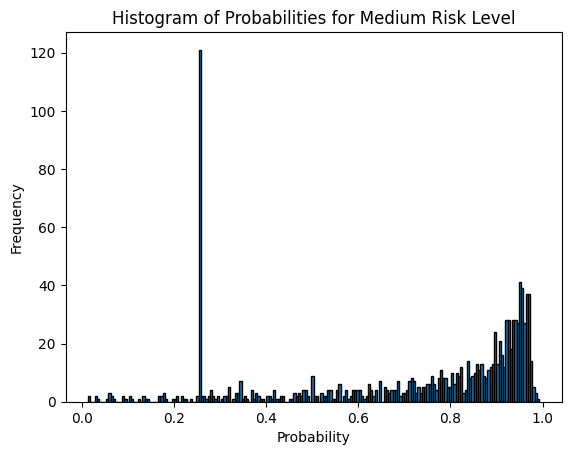

In [16]:
medium_risk_df = ytrain_comp[ytrain_comp['risk_level'] == 'Medium']

# Plot the histogram of the 'prob' column for these rows
plt.hist(medium_risk_df['prob'], bins=200, edgecolor='black')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Probabilities for Medium Risk Level')
plt.show()

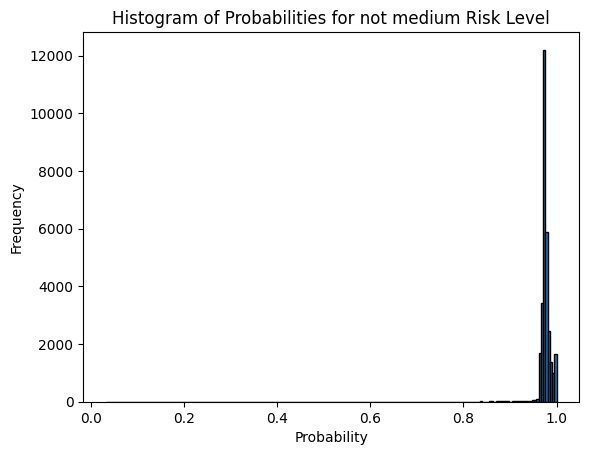

In [17]:
not_medium_risk_df = ytrain_comp[ytrain_comp['risk_level'] == 'Not Medium']

# Plot the histogram of the 'prob' column for these rows
plt.hist(not_medium_risk_df['prob'], bins=200, edgecolor='black')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Probabilities for not medium Risk Level')
plt.show()

[0.98147129 0.97395573 0.98106734 ... 0.54044082 0.96218858 0.9640429 ]


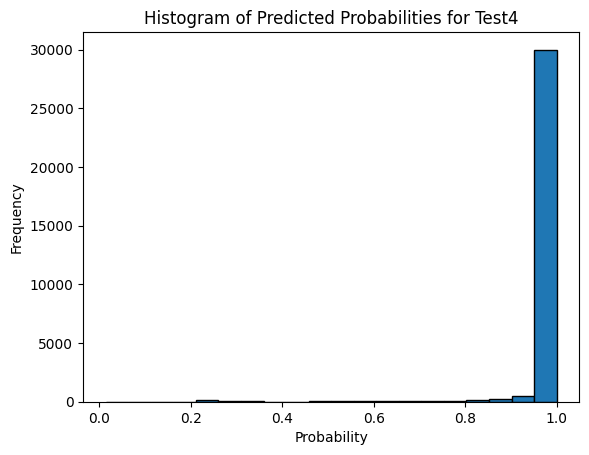

In [13]:
print(y_pred_4_medium_prob)
plt.hist(y_pred_4_medium_prob, bins=20, edgecolor='k')
plt.title('Histogram of Predicted Probabilities for Test4')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

In [32]:
threshold = 0.95
final_predictions_4 = apply_threshold(y_pred_4_medium_prob, threshold)
final_predictions_4 = pd.Series(final_predictions_4, index=X_test4.index)

# Evaluate the results
df2_test4_ = df2_test4.copy()
df2_test4_['risk_level_binary'] = df2_test4['risk_level'].apply(lambda x: 'Medium' if x == 'Medium' else 'Not Medium')

# Create a DataFrame for true labels and predictions
y4_true = pd.DataFrame()
y4_true['risk_level'] = df2_test4_['risk_level_binary']
y4_true['pred'] = final_predictions_4

threshold 0.95


In [33]:
print(y4_true['risk_level'].value_counts())
print(y4_true['pred'].value_counts())
score4 = macro_avg_f1(y4_true['risk_level'], y4_true['pred'])
print('\nScores1 Details:\n', score4)
accuracy = (y4_true['risk_level'] == y4_true['pred']).mean()
print("Accuracy:", accuracy)

risk_level
Not Medium    30344
Medium         1143
Name: count, dtype: int64
pred
Not Medium    30011
Medium         1476
Name: count, dtype: int64

Scores1 Details:
 0.86
Accuracy: 0.9775462889446438


In [34]:
high_low_filter = y_train != 'Medium'
X_train_high_low = X_train[high_low_filter]
y_train_high_vs_low = y_train[high_low_filter]
X_train_high_low_scaled = scaler.transform(X_train_high_low)

In [35]:
print(len(y_train_high_vs_low))

30344


In [36]:
#classifier_high_vs_medium = SVC(kernel='poly', probability=True, random_state=42)
classifier_high_vs_low = SVC(kernel='linear', decision_function_shape='ovr', probability=True, random_state=42)
classifier_high_vs_low.fit(X_train_high_low_scaled, y_train_high_vs_low)

SVC(kernel='linear', probability=True, random_state=42)

In [37]:
X_test4_hl = df2_test4.drop(columns=['ChassisId_encoded', 'gen', 'risk_level', 'v_category'])
X_test4_hl = X_test4_hl[high_low_filter]
X_test4_hl_scaled = scaler.transform(X_test4_hl)

# Predict probabilities for each class
y_pred_4_hl_prob = classifier_high_vs_low.predict_proba(X_test4_hl_scaled)[:, 1]

In [38]:
yhl_train_comp = pd.DataFrame()
yhl_train_comp['risk_level'] = y_train_high_vs_low
yhl_train_comp['prob'] = y_pred_4_hl_prob
yhl_train_comp.head()

,risk_level,prob
0,Low,1.000000
1,Low,1.000000
2,Low,1.000000
3,Low,1.000000
4,Low,0.999997


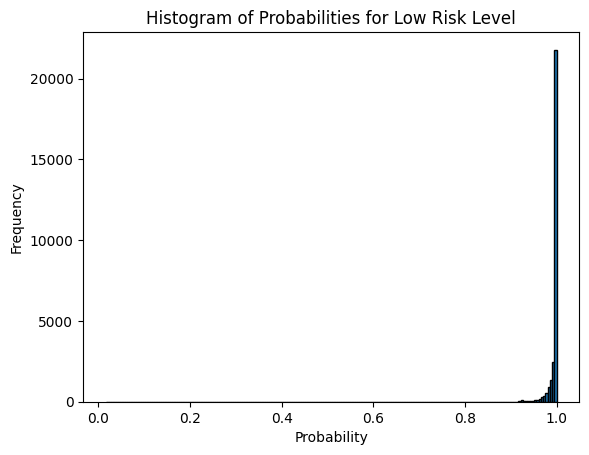

In [40]:
low_risk_df = yhl_train_comp[yhl_train_comp['risk_level'] == 'Low']

# Plot the histogram of the 'prob' column for these rows
plt.hist(low_risk_df['prob'], bins=200, edgecolor='black')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Probabilities for Low Risk Level')
plt.show()

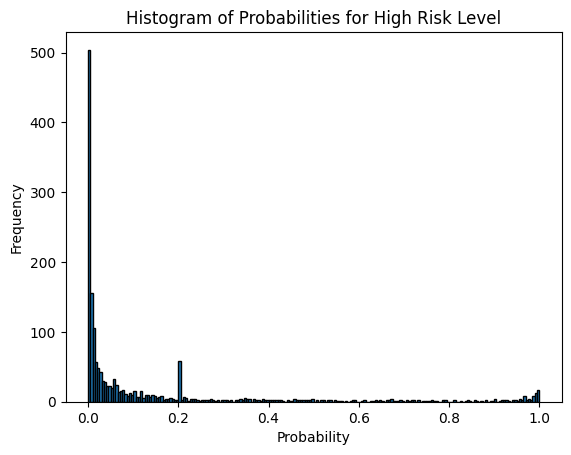

In [41]:
high_risk_df = yhl_train_comp[yhl_train_comp['risk_level'] == 'High']

# Plot the histogram of the 'prob' column for these rows
plt.hist(high_risk_df['prob'], bins=200, edgecolor='black')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Probabilities for High Risk Level')
plt.show()

[1.         1.         0.99999999 ... 0.99999744 0.10198405 0.02505561]


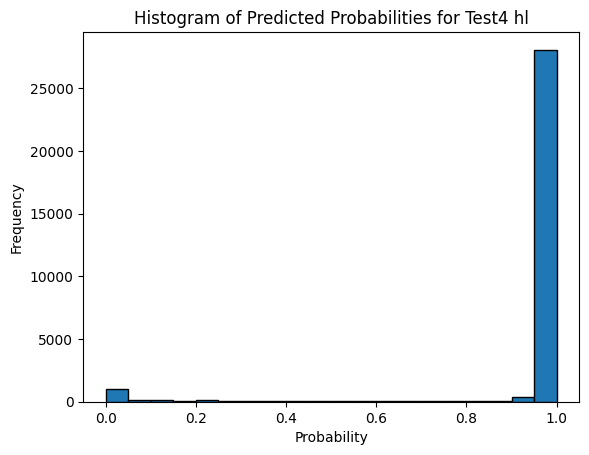

In [42]:
print(y_pred_4_hl_prob)
plt.hist(y_pred_4_hl_prob, bins=20, edgecolor='k')
plt.title('Histogram of Predicted Probabilities for Test4 hl')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

In [44]:
def apply_threshold_hl(probs, threshold=0.5):
    print("threshold", threshold)
    return np.where(probs <= threshold, 'High', 'Low')

In [47]:
threshold = 0.7
final_predictions_4_hl = apply_threshold_hl(y_pred_4_hl_prob, threshold)
final_predictions_4_hl = pd.Series(final_predictions_4_hl, index=X_test4_hl.index)

# Evaluate the results
#df2_test4_ = df2_test4.copy()
#df2_test4_['risk_level_binary'] = df2_test4['risk_level'].apply(lambda x: 'Low' if x == 'Low' else 'Not Low')

# Create a DataFrame for true labels and predictions
y4_true_hl = pd.DataFrame()
y4_true_hl['risk_level'] = y_train_high_vs_low
y4_true_hl['pred'] = final_predictions_4_hl

threshold 0.7


In [48]:
print(y4_true_hl['risk_level'].value_counts())
print(y4_true_hl['pred'].value_counts())
score4_hl = macro_avg_f1(y4_true_hl['risk_level'], y4_true_hl['pred'])
print('\nScores4_hl Details:\n', score4_hl)
accuracy = (y4_true_hl['risk_level'] == y4_true_hl['pred']).mean()
print("Accuracy:", accuracy)

risk_level
Low     28650
High     1694
Name: count, dtype: int64
pred
Low     28606
High     1738
Name: count, dtype: int64

Scores4_hl Details:
 0.96
Accuracy: 0.9909702082784075


[0.97824021 0.97786005 0.97235805 ... 0.51659999 0.95574541 0.96749363]


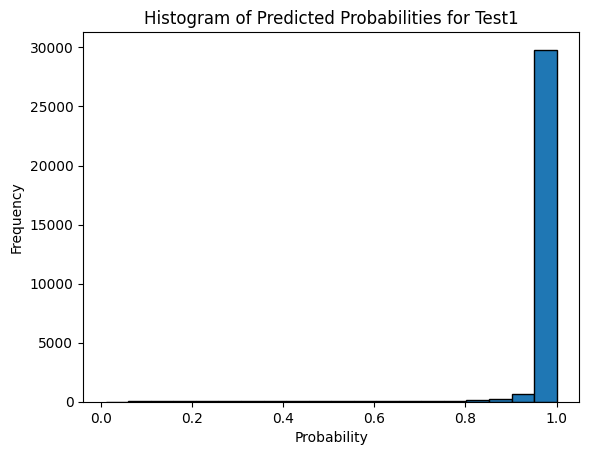

threshold 0.95
risk_level
Not Medium    30353
Medium         1135
Name: count, dtype: int64
pred
Not Medium    29812
Medium         1676
Name: count, dtype: int64

Scores1 Details:
 0.81
Accuracy: 0.9668762703252033


In [51]:
X_test1 = df2_test1.drop(columns=['ChassisId_encoded', 'gen', 'risk_level', 'v_category'])
X_test1_scaled = scaler.transform(X_test1)

# Predict probabilities for each class
y_pred_1_medium_prob = classifier_medium_vs_rest.predict_proba(X_test1_scaled)[:, 1]
print(y_pred_1_medium_prob)
plt.hist(y_pred_1_medium_prob, bins=20, edgecolor='k')
plt.title('Histogram of Predicted Probabilities for Test1')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()
threshold = 0.95
final_predictions_1 = apply_threshold(y_pred_1_medium_prob, threshold)
final_predictions_1 = pd.Series(final_predictions_1, index=X_test1.index)

# Evaluate the results
df2_test1_ = df2_test1.copy()
df2_test1_['risk_level_binary'] = df2_test1['risk_level'].apply(lambda x: 'Medium' if x == 'Medium' else 'Not Medium')

# Create a DataFrame for true labels and predictions
y1_true = pd.DataFrame()
y1_true['risk_level'] = df2_test1_['risk_level_binary']
y1_true['pred'] = final_predictions_1

print(y1_true['risk_level'].value_counts())
print(y1_true['pred'].value_counts())
score1 = macro_avg_f1(y1_true['risk_level'], y1_true['pred'])
print('\nScores1 Details:\n', score1)
accuracy = (y1_true['risk_level'] == y1_true['pred']).mean()
print("Accuracy:", accuracy)

not_medium_indices_1 29812
[0.01816554 1.         1.         ... 0.99999995 0.05642766 0.01308397]
29812


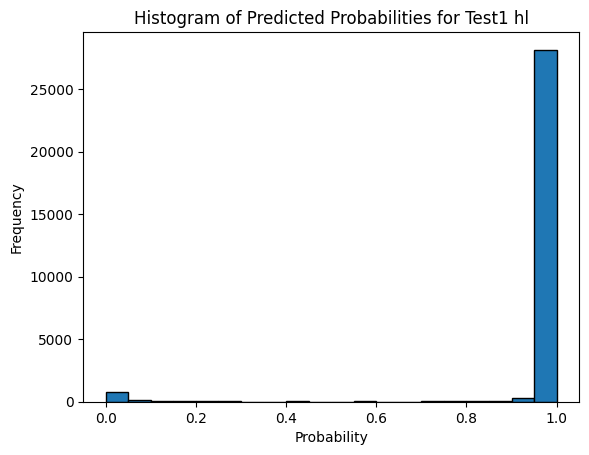

threshold 0.7
risk_level
Low       28706
High       1647
Medium     1135
Name: count, dtype: int64
pred
Low       28611
Medium     1676
High       1201
Name: count, dtype: int64

Scores1 Details:
 0.79
Accuracy: 0.9628429878048781


In [52]:
not_medium_indices = y1_true[y1_true['pred'] == 'Not Medium'].index
print("not_medium_indices_1",len(not_medium_indices))
X_test1_high_low = X_test1.iloc[not_medium_indices]
#y_test1_high_vs_medium = y_train[high_medium_filter]
X_test1_high_low_scaled = scaler.transform(X_test1_high_low)

y_pred_1_hl = classifier_high_vs_low.predict_proba(X_test1_high_low_scaled)[:, 1]
print(y_pred_1_hl)
print(len(y_pred_1_hl))
plt.hist(y_pred_1_hl, bins=20, edgecolor='k')
plt.title('Histogram of Predicted Probabilities for Test1 hl')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

threshold = 0.7
final_predictions_1_hl = apply_threshold_hl(y_pred_1_hl, threshold)
final_predictions_1_hl = pd.Series(final_predictions_1_hl, index=X_test1_high_low.index)
matching_indices_1 = y1_true.index.intersection(final_predictions_1_hl.index)

# Update the 'pred' column in y1_true where indices match
y1_true.loc[matching_indices_1, 'pred'] = final_predictions_1_hl.loc[matching_indices_1]
y1_true['risk_level'] = df2_test1['risk_level']
print(y1_true['risk_level'].value_counts())
print(y1_true['pred'].value_counts())
score1 = macro_avg_f1(y1_true['risk_level'], y1_true['pred'])
print('\nScores1 Details:\n', score1)
accuracy = (y1_true['risk_level'] == y1_true['pred']).mean()
print("Accuracy:", accuracy)